In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import utils 
import itertools

WACC = utils.WACC
N = utils.N

In [2]:
h2_costs = pd.read_excel('./h2_tech.xlsx', sheet_name='Summary')
h2_costs['H2 eff (kgh2/MWhe)'] = h2_costs.apply(lambda d: d['H2Cap (kgh2/h)']/d['H2Cap (MWe)'], axis=1)
h2_eff = h2_costs[['Technology', 'ANR', 'H2 eff (kgh2/MWhe)']]
h2_costs =h2_costs[['Technology', 'CAPEX ($/MWe)', 'FOM ($/MWe-year)', 'VOM ($/MWhe)', 'Life (y)']]

h2_costs.drop_duplicates(ignore_index=True, inplace=True)
h2_costs['CRF'] = h2_costs.apply(lambda d: WACC/ (1-np.power(1+WACC, -d['Life (y)'])), axis =1)
h2_tech_list = list(h2_costs['Technology'])
h2_costs.set_index('Technology', inplace=True)
h2_eff.set_index(['Technology','ANR'], inplace=True)
h2_costs


,CAPEX ($/MWe),FOM ($/MWe-year),VOM ($/MWhe),Life (y),CRF
Technology,,,,,
HTSE,646487,30313.2,2.76,20,0.099589
PEM,1500000,12800.0,1.30,20,0.099589
Alkaline,743865,60020.0,0.00,20,0.099589


In [3]:
anr_params = pd.read_excel('./ANRs.xlsx', sheet_name='FOAK')
reactors_list = list(anr_params['Reactor'])
anr_params.set_index('Reactor', inplace=True)
anr_params['CRF'] = anr_params.apply(lambda d: WACC/ (1-np.power(1+WACC, -d['Life (y)'])), axis =1)
anr_params

,Type,Power in MWe,Power in MWt,MSL in MWe,Thermal Efficiency,Thermal transfer efficiency,MDT in hours,Ramp Rate (fraction of capacity/hr),Ramp Rate (MW/hr),Outlet Temp (C),CAPEX $/MWe,FOPEX $/MWe-y,Max Modules,VOM in $/MWh-e,Startupfixedcost in $,Life (y),CRF
Reactor,,,,,,,,,,,,,,,,,
iPWR,PWR,77.0,250,15.4,0.31,1.000,20,0.4,24.0,302,5535000,115000,12,9.75,38500,60,0.077909
HTGR,HTGR,164.0,350,32.8,0.47,0.897,20,6.0,984.0,950,7500000,164000,4,13.00,82000,60,0.077909
PBR-HTGR,HTGR,80.0,200,32.0,0.40,0.751,20,2.4,48.0,750,4569000,100000,12,13.00,40000,60,0.077909
iMSR,MSR,141.0,300,28.2,0.47,0.936,20,0.6,84.6,700,4091000,85000,12,11.50,70500,60,0.077909
Micro,HTGR,6.7,20,2.7,0.33,0.897,20,6.0,24.0,630,10902000,264000,12,0.00,3350,20,0.099589


In [4]:
lcoh_df = pd.DataFrame(columns=['Reactor', 'H2 tech', 'LR (%)', 'LCOH ($/kg)'])
lcoh_df.set_index(['Reactor','H2 tech', 'LR (%)'], inplace=True)
learning_rates = [0, 0.03, 0.07,0.1]
combinations = list(itertools.product(reactors_list, h2_tech_list, learning_rates))

def update_capex_anr(capex_foak, lr):
  return capex_foak*np.power(N, np.log2(1-lr))

for tup in combinations:
  r = tup[0]
  h = tup[1]
  lr = tup[2]
  anr_capex = update_capex_anr(anr_params.loc[r, 'CAPEX $/MWe'], lr)
  r_num = anr_params.loc[r, 'Power in MWe']*(anr_capex*anr_params.loc[r, 'CRF'] + anr_params.loc[r, 'FOPEX $/MWe-y'] +\
                                             anr_params.loc[r,'VOM in $/MWh-e']*365*24)
  h_num = anr_params.loc[r, 'Power in MWe']*(h2_costs.loc[h, 'CAPEX ($/MWe)']*h2_costs.loc[h,'CRF'] + h2_costs.loc[h,'FOM ($/MWe-year)'] +\
                                             h2_costs.loc[h, 'VOM ($/MWhe)']*365*24)
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
  lcoh = (r_num+h_num)/den 
  lcoh_df.loc[r, h, lr] = lcoh 

lcoh_df



C:\Users\mgarrou\AppData\Local\Temp\ipykernel_19204\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_19204\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  den = h2_eff.loc[h, r][0]*365*24*anr_params.loc[r,'Power in MWe']
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_19204\1810158657.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access

LCOH ($/kg)
Reactor  H2 tech  LR (%)             
iPWR     HTSE     0.00       2.828090
                  0.03       2.402665
                  0.07       1.991538
                  0.10       1.771766
         PEM      0.00       9.283800
                  0.03       7.982119
                  0.07       6.724188
                  0.10       6.051747
         Alkaline 0.00       4.720303
                  0.03       4.024355
                  0.07       3.351797
                  0.10       2.992275
HTGR     HTSE     0.00       2.556165
                  0.03       2.157582
                  0.07       1.772395
                  0.10       1.566490
         PEM      0.00      11.942101
                  0.03      10.178305
                  0.07       8.473791
                  0.10       7.562625
         Alkaline 0.00       6.141573
                  0.03       5.198553
                  0.07       4.287229
                  0.10       3.800071
PBR-HTGR HTSE     0.00       1.622739
                  0.03       1.403158
                  0.07       1.190956
                  0.10       1.077521
         PEM      0.00       8.571378
                  0.03       7.496874
                  0.07       6.458484
                  0.10       5.903402
         Alkaline 0.00       4.339404
                  0.03       3.764917
                  0.07       3.209738
                  0.10       2.912961
iMSR     HTSE     0.00       1.523683
                  0.03       1.319712
                  0.07       1.122596
                  0.10       1.017226
         PEM      0.00       7.817561
                  0.03       6.855469
                  0.07       5.925714
                  0.10       5.428703
         Alkaline 0.00       3.936373
                  0.03       3.421988
                  0.07       2.924891
                  0.10       2.659162
Micro    HTSE     0.00       2.880052
                  0.03       2.322613
                  0.07       1.783909
                  0.10       1.495940
         PEM      0.00      17.563059
                  0.03      14.285760
                  0.07      11.118612
                  0.10       9.425579
         Alkaline 0.00       9.146837
                  0.03       7.394618
                  0.07       5.701292
                  0.10       4.796106

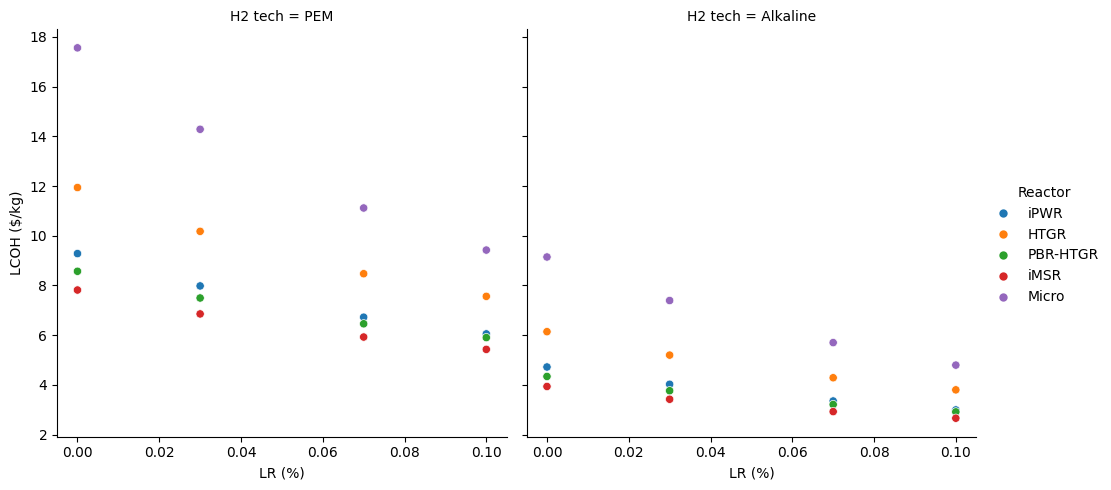

In [5]:
lcoh_df = lcoh_df.reset_index()
import seaborn as sns 


#sns.scatterplot(data=lcoh_df, x='LR (%)', y='LCOH ($/kg)', hue='Reactor', style='H2 tech')
sns.relplot(
    data=lcoh_df[lcoh_df['H2 tech'] !='HTSE'], x='LR (%)', y='LCOH ($/kg)',
    col="H2 tech", hue="Reactor",
    kind="scatter"
)
plt.savefig('./results/lcoh_pem_ael.png')

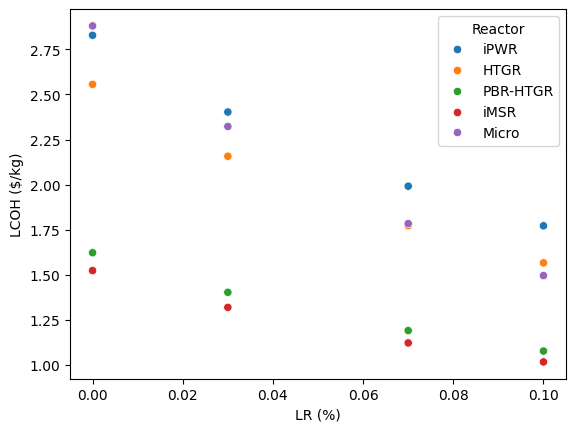

In [6]:
sns.scatterplot(data=lcoh_df[lcoh_df['H2 tech']=='HTSE'], x='LR (%)', y='LCOH ($/kg)', hue='Reactor')
plt.savefig('./results/lcoh_htse.png')

In [7]:
lcoh_foak = lcoh_df[lcoh_df['LR (%)'] ==0]
lcoh_foak.to_excel('./results/lcoh_foak.xlsx')